- https://github.com/Coding-Crashkurse/LangGraph-Tutorial/blob/main/langgraph.ipynb
- https://www.youtube.com/watch?v=J5d1l6xgQBc

# LangGraph 소개: 핵심 개념 빠르게 알아보기

### LangGraph와 에이전트

- LangGraph는 LangChain 위에 구축되어 있으며, 주로 에이전트 및 에이전틱 워크플로우를 생성하는 데 사용됩니다.
- 에이전트는 LLM을 사용하여 일련의 작업을 결정하며, LangGraph는 여러 에이전트를 결합해 데이터 공유와 작업 수행을 가능하게 합니다.
- LangGraph는 Crew AI나 Autogen과 달리 더 깊이 있는 이해와 세밀한 맞춤 설정을 제공합니다.
    - CrewAI: https://www.crewai.com/
    - Autogen: https://microsoft.github.io/autogen/

### 기본 예제와 실습
- LangGraph의 기본 개념을 이해하기 위해 간단한 예제를 통해 시작합니다.
- 설치 방법: pip install langgraph, AzureOpenAI API 키 설정 필요.
- 노드와 엣지 추가, 시작 지점 설정, 그래프 컴파일 및 시각화를 시연합니다.

### LangGraph의 핵심 개념
- 노드(Nodes) : 그래프 내 특정 작업을 수행하는 함수 또는 실행 가능한 코드.
- 엣지(Edges) : 노드 간의 연결 및 흐름을 정의하여 실행 순서를 결정. 조건부 엣지는 현재 상태에 따라 실행을 라우팅할 수 있음.
- 상태(State) : 실행 중에 노드 간에 전달되는 데이터로, 동적 워크플로우를 가능하게 함.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

Agent 함수 생성

In [2]:
# node 함수 - agent 생성
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

# def add_one(mark, input: list[HumanMessage]):
#     input[0].content = input[0].content + mark
#     return input

# 간단한 메시지 출력 Node 함수
def add_one(mark: str):
    def action(messages: list[HumanMessage]):
        print(f"befor content: {messages[0].content}") # 입력 값 출력 전 메시지
        messages[0].content += mark     
        print(f"after content: {messages[0].content}") # 입력 값 출력 메시지  
        return messages
    return action

Node 생성

In [3]:
# graph 객체 생성
graph = MessageGraph()

# node 생성
graph.add_node("branch_a", add_one("a")) # + a
graph.add_node("branch_b", add_one("b")) #a + b
graph.add_node("branch_c", add_one("c")) #ab + c
graph.add_node("final_node", add_one("f")) #abc + f

Edge 연결

In [4]:
# node를 연결하는 edge 생성
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")
graph.add_edge("final_node", END) # 마지막 node

Graph 설정 및 컴파일

In [5]:
# graph 진입 노드 설정
graph.set_entry_point("branch_a")

# graph 컴파일
sample_graph = graph.compile()

Graph 시각화

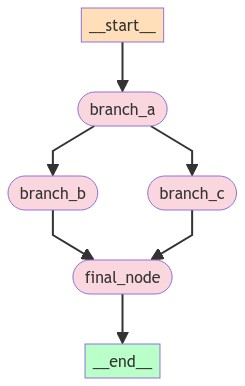

In [6]:
from IPython.display import Image, display

display(Image(sample_graph.get_graph().draw_mermaid_png()))

In [7]:
# 워크플로우 실행
# 입력 값이 공유됨을 확인
sample_graph.invoke("z")

befor content: z
after content: za
befor content: za
after content: zab
befor content: zab
after content: zabc
befor content: zabc
after content: zabcf


[HumanMessage(content='zabcf', id='5576ebfe-10e2-4929-a6ba-ad1b0c8656d9')]

### 조건부 edge와 순환 그래프
- 조건부 edge를 사용하여 입력에 따라 다른 작업을 수행할 수 있음.
- LangGraph는 조건부 체크를 기반으로 반복 작업을 수행할 수 있는 순환 워크플로우를 지원하여 전통적인 표현 언어가 지원하지 않는 사이클을 가능하게 합니다.

### Conditional Edges (조건부 엣지)

Agent 함수 생성

In [8]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

# 시작 node 함수
def entry(input: list[HumanMessage]):
    return input

# branch b node 함수
def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return input

# branch c node 함수
def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return input

# 조건 분기 함수
def router(input: list[HumanMessage]):
    if "use_b" in input[0].content: # 'use_b' 라는 문자열이 포함된 경우
        return "branch_b"
    else:
        return "branch_c"

Node 생성

In [9]:
# graph 객체 생성    
graph = MessageGraph()

# node 생성
graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

Edge 생성

In [10]:
# 조건 분기 edge 생성
graph.add_conditional_edges(
    "branch_a", # 시작 node 에서
    router,     # 분기 node 로
    {
        "branch_b":"branch_b", # 분기 node의 반환값에 따라 해당 node로 이동
        "branch_c":"branch_c"
    }
)

# edge 생성
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

Graph 설정 및 컴파일

In [11]:
# 진입 node 설정
graph.set_entry_point("branch_a")

# graph 컴파일
runnable = graph.compile()

Graph 시각화

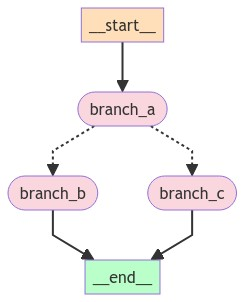

In [12]:
# 시각화
display(Image(runnable.get_graph().draw_mermaid_png()))

Graph 실행

In [13]:
# 워크플로우 실행
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', id='dbbe6ecf-1c6e-496e-8b39-2a51545840c8')]

In [14]:
# 조건 분기
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', id='0aa080af-927f-4ad0-952a-227bfab51d9d')]

### Cycles (순환 graph)

Agent 생성

In [15]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph
import os

# 시작 node
def entry(input: list[HumanMessage]):
    return input

# 순환 node
def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5: # list 배열의 크기가 5보다 크면 'end' 문자열 삽입
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

# 조건 분기 함수
def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content: # 메시지 내에 end 문자열이 있으면 종료
        return "__end__"
    return "action"

Node 생성

In [16]:
# graph 객체 생성
graph = MessageGraph()

# node 생성
graph.add_node("agent_node", entry)
graph.add_node("action_node", action)

Edge 생성

In [17]:
# 조건 분기 edge 생성
graph.add_conditional_edges(
    "agent_node",
    should_continue,
    {
        "action": "action_node", 
        "__end__": END
    }
)

# edge 생성
graph.add_edge("action_node", "agent_node")

컴파일

In [18]:
# graph 진입점 설정
graph.set_entry_point("agent_node")

# graph 컴파일
runnable = graph.compile()

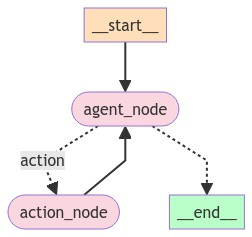

In [19]:
# 시각화
display(Image(runnable.get_graph().draw_mermaid_png()))

In [20]:
# 워크플로우 실행
runnable.invoke("Hello")

Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', id='0eb9218c-6dac-43de-bc3e-4b9f6b906e09'),
 HumanMessage(content='continue', id='9e1cfe09-8e77-4329-a677-4782d9d0cba8'),
 HumanMessage(content='continue', id='cda3e265-2d95-4529-8445-9b3c6020a095'),
 HumanMessage(content='continue', id='39e2dce9-c4c5-4bf7-a90a-c6778a8df755'),
 HumanMessage(content='continue', id='e2393b42-5386-4e32-b253-5973b70bfc92'),
 HumanMessage(content='continue', id='1d6082ac-559d-4e98-ae91-184ea0ec2da6'),
 HumanMessage(content='end', id='7f827385-bb7d-43b7-a209-2702a8f6ce4e')]

Real Agent - 실제로 특정 작업을 수행하는 Agent를 만들어서 Graph를 구현해 보겠습니다.

LLM 생성

In [21]:
from langchain_openai import AzureChatOpenAI
import os

os.environ["AZURE_OPENAI_API_KEY"] = '6515701982584d9b9c03317591233c46'
os.environ["AZURE_OPENAI_ENDPOINT"] = 'https://aoai-spon-estus1.openai.azure.com/'

# LLM 객체 생성
model = AzureChatOpenAI(  
  api_version = '2024-02-01',
  azure_deployment = 'gpt-4o-spon-gb',
  temperature = 0.0
)

상태 정보 클래스

In [22]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

# 메시지 상태 정보 저장 클래스
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] # 메시지 배열 변수, operator.add 옵션으로 자동 추가
    api_call_count: int = 0 # API Call 횟수

Agent 함수 생성

In [23]:
from langchain_core.tools import tool
import random

# 가짜 날씨 정보를 제공하는 Custom Tool 함수
# 지정된 도시의 날씨를 확인하세요. API는 대략 세 번째 호출마다 무작위로 이용 가능합니다.
@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 3) == 1: # 1~3 사이의 숫자 중에서 랜덤하게 반환된 값이 1인 경우
        return "Sunny, 22℃" # 날씨 출력
    else:
        return "Service temporarily unavailable" # 서버 오류라는 메시지 출력

In [24]:
# API 테스트
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))
print(fake_weather_api("Seoul"))

Service temporarily unavailable
Sunny, 22℃
Sunny, 22℃
Service temporarily unavailable


c:\Users\bhkim\AppData\Local\miniconda3\envs\azure_analy\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [25]:
# LLM 객체와 Tool 함수 연결
llm_with_tools = model.bind_tools([fake_weather_api])

In [26]:
# llm_tool 테스트
messages = [HumanMessage("오늘 서울 날씨는 어떨까요? 가능하다면 밖에서 식사하고 싶습니다.")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='오늘 서울 날씨는 어떨까요? 가능하다면 밖에서 식사하고 싶습니다.'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RiwGwIaSbnVCpuWmjWqH9wWv', 'function': {'arguments': '{"city":"Seoul"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 77, 'total_tokens': 93}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-3f57672f-e2fd-4bb6-b49c-a6d1d1859622-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Seoul'}, 'id': 'call_RiwGwIaSbnVCpuWmjWqH9wWv'}], usage_metadata={'input_tokens': 77, 'output_to

In [27]:
from langchain_core.messages import HumanMessage, ToolMessage

# 호출할 tool 함수 목록
tool_mapping = {"fake_weather_api": fake_weather_api}

for tool_call in llm_output.tool_calls: # AIMessage에서 tool_calls 항목 탐색    
    tool = tool_mapping[tool_call["name"].lower()] # 호출할 tool 함수 목록에서 tool 함수 객체를 가져온다.
    tool_output = tool.invoke(tool_call["args"]) # tool_calls 항목에서 인자를 추출하고 tool 함수에 입력하여 실행한다.
    tool_msg = ToolMessage(content=tool_output, tool_call_id=tool_call["id"]) # tool 함수의 반환값으로 ToolMessage를 생성
    print(f"tool message: {tool_msg}")
    messages.append(tool_msg) # ToolMessage를 메시지 배열에 추가하여 프롬프트로 사용한다.

llm_with_tools.invoke(messages) # llm_tool 실행

tool message: content='Sunny, 22℃' tool_call_id='call_RiwGwIaSbnVCpuWmjWqH9wWv'


AIMessage(content='오늘 서울 날씨는 맑고 기온은 22℃입니다. 밖에서 식사하기에 좋은 날씨네요! 즐거운 시간 보내세요.', response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 107, 'total_tokens': 142}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}, id='run-b9797987-0b7f-4117-ac8d-33fffc3cb2a3-0', usage_metadata={'input_tokens': 107, 'output_tokens': 35, 'total_tokens': 142})

In [28]:
# 사용자 질문을 LLM에게 질의하는 시작 node
# tool을 실행하기 위한 정보 반환     
def call_model(state: AgentState):
    print("call_model - STATE:", state)
    messages = state["messages"] # 프롬프트 배열을 가져온다
    print("call_model - messages:", messages)
    response = llm_with_tools.invoke(messages) # llm_tool 실행
    print("call_model - response:", response)
    return {"messages":[response], "api_call_count":state["api_call_count"]}

# tool 실행 node
def call_tool(state:AgentState):
    print("call_tool - STATE:", state)
    messages = state["messages"] # 프롬프트 배열을 가져온다
    last_message = messages[-1] # tool 함수 정보가 담긴 마지막 프롬프트 메시지를 가져온다.
    print("call_tool - last_message:", last_message)

    tool_call = last_message.tool_calls[0] # tool 함수 항목을 가져온다. 
    tool = tool_mapping[tool_call["name"].lower()] # tool 이름을 가져온다
    tool_output = tool.invoke(tool_call["args"]) # tool 함수 실행에 필요한 인자값을 가져와서 tool 함수를 호출한다.
    state['api_call_count'] += 1 # tool 호출 횟수 증가
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state['api_call_count'])

    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"]) # tool 함수의 결과로 ToolMessage 객체 생성
    print("call_tool - tool_message:", tool_message)
    
    return {"messages": [tool_message], "api_call_count":state["api_call_count"]} # 상태 객체 업데이트하여 반환

# 조건 체크 node 함수
def should_continue(state: AgentState):
    print("should_continue - STATE:", state)    
    messages = state["messages"] # 프롬프트 배열을 가져온다
    print("should_continue - messages:", messages)
    last_message = messages[-1] # 메시지 배열에서 마지막 메시지를 가져온다.
    print("should_continue - last_message:", last_message)
    if not last_message.tool_calls: # 마지막 메시지에 'tool_calls' 함수 항목이 없으면 답변을 얻었다는 것이므로 종료
        print("should_continue - end:")    
        return "end"
    else:
        print("should_continue - continue:")
        return "continue" # 마지막 메시지에 'tool_calls' 함수 항목이 있으면, tool을 호출해서 답변을 얻으라는 것이므로 계속 진행


Node 생성 및 Edge 연결

In [29]:
from langgraph.graph import StateGraph, END

# 상태 grape 객체 생성
workflow = StateGraph(AgentState)

# node 생성
workflow.add_node("agent_call_model", call_model)
workflow.add_node("action_call_tool", call_tool)

# 조건 분기 edge 생성
workflow.add_conditional_edges(
    "agent_call_model",
    should_continue,
    {
        "continue": "action_call_tool", # AI 답변이 없고, 마지막 상태 메시지에 tool call 함수 항목이 존재하는 경우
        "end": END, # tool call 메시지가 없고 AI 답변이 있는 경우
    }
)

# edge 생성
workflow.add_edge("action_call_tool", "agent_call_model")



컴파일

In [30]:
# 시작 node 설정
workflow.set_entry_point("agent_call_model")

# graph 컴파일
app = workflow.compile()

시각화

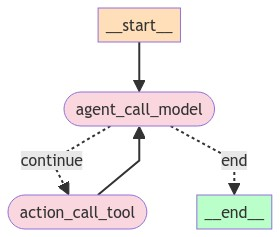

In [31]:
# 시각화

from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

Graph 실행

In [32]:
from langchain_core.messages import SystemMessage

# 사용자 질문에 답변하는 책임이 있습니다. 이를 위해 도구를 사용합니다. 이러한 도구들이 때때로 실패할 수 있지만, 당신은 매우 끈질기게 다시 시도합니다.
system_message = SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")

# 오늘 서울의 날씨는 어때?
human_message = HumanMessage(content="오늘 서울의 날씨는 어때?")

# 프롬프트 생성
messages = [system_message, human_message]

# graph 실행
result = app.invoke({"messages":messages, "api_call_count":0})

call_model - STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='오늘 서울의 날씨는 어때?')], 'api_call_count': 0}
call_model - messages: [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='오늘 서울의 날씨는 어때?')]
call_model - response: content='' additional_kwargs={'tool_calls': [{'id': 'call_anu2OuIGhMGThzNQoThb1k7p', 'function': {'arguments': '{"city":"Seoul"}', 'name': 'fake_weather_api'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 94, 'total_tokens': 110}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'seve

In [33]:
print(result["messages"][-1].content) # 답변 출력
print(result["api_call_count"]) # tool 호출 횟수

오늘 서울의 날씨는 맑고 기온은 22℃입니다.
1
